# Tarea Semanal 5:  Estimación espectral: Ancho de banda de señales reales#

## Descripción ##


En la siguiente tarea, se busca analizar la informaciñon espectral en señales registradas de diversas fuentes. Para abordar el análisis, se empleó el método de Welch para estimar la densidad espectral de potencia, con el obtejito de identificar características de frecuencia relevantes y calcular el ancho de banda efectivo para la señal elegida.
En este caso, se estudió una señal de pletismografía (PPG), se trata de una señal registrada en reposo, que corresponde a la varaicion del volumen sanguíneo mediada ópticamente en un dedo. Dicha señal tposee una periodicidad (similar a un ECG), pero su forma espectral difiere.

## Metodología 

Para realizar la estimación espectral (obtención de a PSD), se utilizó el método de Welch. Este método mejora la estimación espectral respecto del periodograma ventaneado, puesto que reduce significativamente su varianza al costo de un empeoramiento de la resolución espectral e incremento del costo computacional. Dicho método consiste en una estimación mediante el promediado de múltiples periodogramas calculados sobre segmentos solapados de la señal. 

### Validez teórica

El método de Welch consiste en un promedio de periodogramas, es decir que estima la densidad espectral de potencia basándose en el Teorema de Parseval, que establece que la energía total de una señal es la misma si se calcula en el dominio del tiempo o en el dominio de la frecuencia.

$ \sum_{n=0}^{N-1} |x[n]|^2 = \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2 $

donde $ x[n] $ es la señal en el tiempo y $X[k]$ es su Transformada Discreta de Fourier (DFT).

Para verificar el teorema de Parseval, se aplico la fft al modulo de la señal del PPG elevada al cuadrado, luego se comparó la sumatoria de dicho resultado en el intervalo total de tiempo con el del modulo del cuadrado de la señal temporal.

In [4]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt

#%%

####################################
# Lectura de pletismografía (PPG)  #
####################################

fs_ppg = 400 # Hz

##################
## PPG sin ruido
##################

ppgsinruido = np.load('ppg_sin_ruido.npy')

ppgsinruido = ppgsinruido.ravel() #aplana un array multidimensional a una sola dimensión.

#%%Corroboramos teo de parseval

energiaTiempo = np.sum(ppgsinruido**2)
X = np.fft.fft(ppgsinruido)
energiaFreq = np.sum(np.abs(X)**2) / N

print("EN Tiempo =", energiaTiempo)
print("EN FRECUENCIA =", energiaFreq)
print("RESTA =", energiaTiempo - energiaFreq)

EN Tiempo = 12435132275.0
EN FRECUENCIA = 12435132275.0
RESTA = 0.0


En el método de Welch, se obtiene la PSD realizando un promedio de periodogramas en segmentos del intervalo total. En cada uno de los periodogramas se obtiene una estimación de la energía espectral a través de la DFT, es decir que se aplica el Teorema de Parseval. Esto sugiere que el método de Welch es altamente robusto, ya que utiliza un fundamento teórico confiable, verificable y coherente a nivel conceptual.

### Procedimiento Welch

El procedimiento del método consiste en:
1. Segmentación: la señal se divide en segmentos de igual longitud, que se solapan parcialmente, mejorando la eficiencia espectral y reduciendo sesgo en los bordes.
2. Ventaneo: A cada segmento se le aplica una ventana, que atenua los extremos del intervalo y reduce el efecto del leakage espectral.
3. Calculo del periodograma: se calcula el periodograma ventaneado para cada segmento, es decir que se obtiene la transformada de Fourier en cada segmento y se estima la PSD elevando al cuadrado su módulo.
4. Promediado: Finalmente, se lleva a cabo un promedio de todos los periodogramas, esto reduce la varianza estadística a costa de la disminuición de la resolución espectral.

El solapamiento entre ventajas permite incluir más informacióm de la señal sin aumentar la longitud de cada segmento. Esto además compensa la pérdida de información que se produce por utilizar ventanas que atenuan la información en los bordes de cada intervalo.

### Implementación del método

Frecuencia donde se acumula el 95% de la energía: 3.9 Hz


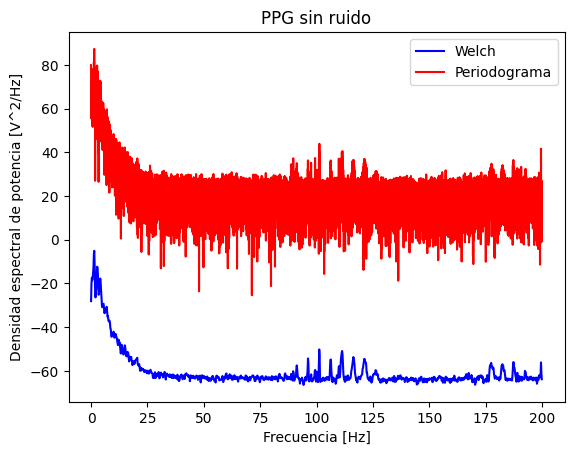

In [3]:

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

#%%

####################################
# Lectura de pletismografía (PPG)  #
####################################

fs_ppg = 400 # Hz

##################
## PPG con ruido
##################

#Cargar el archivo CSV como un array de NumPy
ppgruido = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe


##################
## PPG sin ruido
##################

ppgsinruido = np.load('ppg_sin_ruido.npy')

ppgsinruido = ppgsinruido.ravel() #aplana un array multidimensional a una sola dimensión.
ppgruido = ppgruido.ravel()

ppgvar = np.var(ppgsinruido) #varianza
#ppgvar = np.var(ppgruido)


N = len(ppgsinruido) 
nperseg = N // 20      #  largo total/100
noverlap = nperseg // 2     # solapo 50%
df = fs_ppg/N
ff = np.linspace(0, (N-1)*df, N)
bfrec = ff <= fs_ppg/2

#el sesgo disminuye a medida que se incrementa la longitud del segmento
#la varianza se reduce cuando se incrementa la cantidad de segmentos
#el solapamiento reduce la independencia entre los segmentos.

#la eleccion de ventana trae un tradeoff entre el ancho del lobulo principaly la altura de los lobulos laterales.
#mayor ancho del lobulo = lobulos laterales bajos, = poca varianza y baja resolucion.

#los lobulos laterales determinan el rango dinamico, el ratio entre la amplitud mayor y la menor que podemos distinguir.

f_ppg, Pxxsinruido = sig.welch(ppgsinruido, fs=fs_ppg, window='hamming', nperseg=nperseg, noverlap=noverlap, detrend='linear', scaling='density')


ventana=sig.windows.hamming(N)
Xventana = ppgsinruido * ventana
Xhamming = np.fft.fft(Xventana)
periodograma = np.abs(Xhamming)**2 / N


area_total = np.sum(Pxxsinruido) 

Pxxsinruido_normalizado = Pxxsinruido / area_total 

suma= np.sum(Pxxsinruido_normalizado) #Verifica q este correctamente normalizado


#hamming:reduce lóbulos laterales, mejora contraste).
#normalizamos dividiendo por la varianza, esto impone una escala estandar.



# quiero obtener el bin donde se acumula el 95% de la energia

area = np.cumsum(Pxxsinruido_normalizado)
bin95 = np.where(area >= 0.95)[0][0] #busco el primer bin donde la energia acumulada supera el 95%
freq95 = f_ppg[bin95] 

print(f"Frecuencia donde se acumula el 95% de la energía: {freq95:.1f} Hz")


plt.figure()
plt.plot(f_ppg, 10 * np.log10(Pxxsinruido_normalizado), label='Welch', color='blue')
plt.plot(ff[bfrec],  10 * np.log10(periodograma[bfrec]), label='Periodograma', color='red')

plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [V^2/Hz]')
plt.title('PPG sin ruido')
plt.legend()



Se implementó el método de Welch, para graficarlo junto a un periodograma convencional (con ventana rectandular), lo que permitió observar en forma clara la gran reducción de varianza que se produce en la señal al aplicar el metodo de welch

[ECG] Frecuencia donde se acumula el 95% de la energía: 6.8 Hz
[Audio] Frecuencia donde se acumula el 95% de la energía: 1493.3 Hz


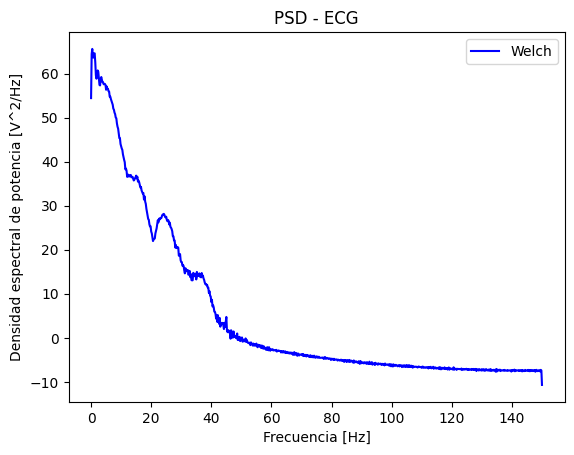

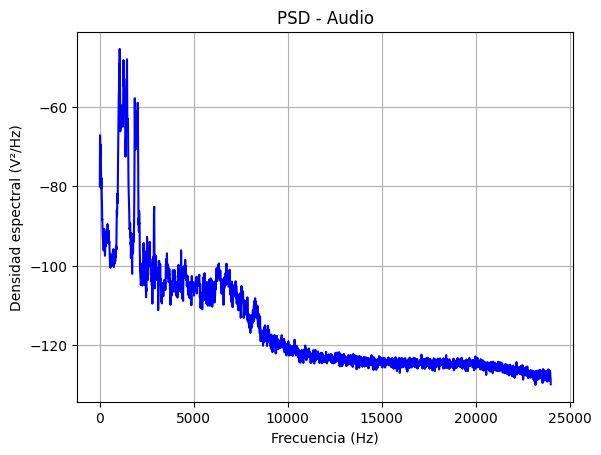

In [5]:
import numpy as np
from scipy import signal as sig
import scipy.io as sio

import matplotlib.pyplot as plt
##################
## ECG sin ruido
##################

fs_ecg = 300

ecg_one_lead = np.load('ecg_sin_ruido.npy')
ecg_one_lead = ecg_one_lead.ravel()

N_ecg = len(ecg_one_lead)
nperseg_ecg = N_ecg // 20
noverlap_ecg = nperseg_ecg // 2

f_ecg, Pxx_ecg = sig.welch(ecg_one_lead, fs=fs_ecg, window='hamming',
                           nperseg=nperseg_ecg, noverlap=noverlap_ecg,
                           detrend='linear', scaling='density')

area_total_ecg = np.sum(Pxx_ecg)
Pxx_ecg_normalizado = Pxx_ecg / area_total_ecg
suma_ecg = np.sum(Pxx_ecg_normalizado)  # Para verificar la normalización

area_ecg = np.cumsum(Pxx_ecg_normalizado)
bin95_ecg = np.where(area_ecg >= 0.95)[0][0]
freq95_ecg = f_ecg[bin95_ecg]

print(f"[ECG] Frecuencia donde se acumula el 95% de la energía: {freq95_ecg:.1f} Hz")


plt.figure()
plt.plot(f_ecg, 10 * np.log10(Pxx_ecg), label='Welch', color='blue')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [V^2/Hz]')
plt.title("PSD - ECG")
plt.legend()

#%%

####################
# Lectura de audio #
####################

# Cargar el archivo CSV como un array de NumPy
fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')
# fs_audio, wav_data = sio.wavfile.read('prueba psd.wav')
# fs_audio, wav_data = sio.wavfile.read('silbido.wav')
wav_data = wav_data.ravel()


N_audio = len(wav_data)
nperseg_audio = N_audio // 20
noverlap_audio = nperseg_audio // 2

f_audio, Pxx_audio = sig.welch(wav_data, fs=fs_audio, window='hamming',
                               nperseg=nperseg_audio, noverlap=noverlap_audio,
                               detrend='linear', scaling='density')

area_total_audio = np.sum(Pxx_audio)
Pxx_audio_normalizado = Pxx_audio / area_total_audio
suma_audio = np.sum(Pxx_audio_normalizado)

area_audio = np.cumsum(Pxx_audio_normalizado)
bin95_audio = np.where(area_audio >= 0.95)[0][0]
freq95_audio = f_audio[bin95_audio]

print(f"[Audio] Frecuencia donde se acumula el 95% de la energía: {freq95_audio:.1f} Hz")

plt.figure()
plt.plot(f_audio, 10 * np.log10(Pxx_audio), label='Welch', color='blue')
plt.title("PSD - Audio")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral (V²/Hz)")
plt.grid()